In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from chemprop.data import MoleculeDatapoint, MoleculeDataset
from chemprop.nn import BondMessagePassing, MeanAggregation, SumAggregation, NormAggregation, AttentiveAggregation, RegressionFFN
from chemprop.models import MPNN, load_model
from chemprop.data import build_dataloader
from chemprop.nn.transforms import UnscaleTransform, ScaleTransform
from chemprop.nn.metrics import RMSE
from chemprop.featurizers import SimpleMoleculeMolGraphFeaturizer

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from mordred import Calculator, descriptors

# Обучение и инференс модели Chemprop для предсказания LogP
Этот Jupyter Notebook посвящён обучению финальной модели Chemprop с использованием оптимальных гиперпараметров и дескрипторов, полученных ранее, а также выполнению инференса на тестовом наборе данных для предсказания LogP.

Объявляем дескрипторы и лучшие параметры, полученные ранее

In [2]:
BEST_PARAMS = {'agg_type': 'sum', 'bias': False, 'd_h': 1500, 'hidden_dim': 2500, 'depth': 3, 'ffn_num_layers': 4, 'batch_norm': True, 'FpDensityMorgan1': 0, 'FpDensityMorgan2': 0, 'HeavyAtomMolWt': 1, 'MolWt': 1, 'NumHDonors': 0, 'NumHAcceptors': 0, 'fr_COO': 0, 'fr_Al_COO': 1, 'fr_Ar_N': 1, 'fr_Al_OH': 1, 'fr_Ar_NH': 0, 'fr_quatN': 0, 'BertzCT': 1, 'NumRings': 0, 'NumAromaticRings': 0, 'NumAromaticCarbocycles': 1, 'NumHeteroatoms': 0, 'TPSA': 1, 'LabuteASA': 1, 'CalcKappa3': 1, 'SLogP': 1, 'PEOE_VSA6': 0, 'PEOE_VSA1': 0, 'C2SP2': 0, 'ZMIC1': 1, 'ZMIC2': 0, 'NaasC': 1, 'NsNh2': 0, 'NsOH': 1, 'NdO': 1, 'nX': 0, 'nN': 0, 'VSA_EState6': 1, 'SMR_VSA7': 0, 'AATS1p': 0, 'AATS1v': 1, 'AATS1i': 1, 'AATS2p': 0, 'AATS2v': 0, 'AATS1se': 1, 'AATS0se': 1, 'AATS4s': 0, 'MATS1Z': 1, 'MATS2d': 0, 'MATS1m': 1, 'MATS1pe': 0, 'MATS1se': 1, 'SlogP_VSA7': 1, 'SlogP_VSA8': 0, 'nAcid': 0, 'nBase': 0, 'FilterItLogS': 0, 'nBondsM': 1, 'MIC0': 0, 'EState_VSA5': 0, 'IC5': 0, 'IC0': 1}

DESCRIPTORS = [
    'FpDensityMorgan1', 'FpDensityMorgan2', 'HeavyAtomMolWt', 'MolWt', 'NumHDonors',
    'NumHAcceptors', 'fr_COO', 'fr_Al_COO', 'fr_Ar_N','fr_Al_OH', 'fr_Ar_NH', 'fr_quatN', 'BertzCT','NumRings', 'NumAromaticRings', 'NumAromaticCarbocycles', 'NumHeteroatoms', 'TPSA', 'LabuteASA', 'CalcKappa3', 'SLogP', 'PEOE_VSA6', 'PEOE_VSA1', 'C2SP2', 'ZMIC1', 'ZMIC2', 'NaasC', 'NsNh2', 'NsOH', 'NdO', 'nX', 'nN', 'VSA_EState6', 'SMR_VSA7', 'AATS1p', 'AATS1v', 'AATS1i', 'AATS2p', 'AATS2v', 'AATS1se', 'AATS0se', 'AATS4s', 'MATS1Z', 'MATS2d', 'MATS1m', 'MATS1pe', 'MATS1se', 'SlogP_VSA7', 'SlogP_VSA8', 'nAcid', 'nBase', 'FilterItLogS', 'nBondsM', 'MIC0', 'EState_VSA5', 'IC5', 'IC0'
    ]

## Очистка данных
Стандартный pipeline очистки, включающий:
1) Удаление выбросов IQR-методом по целевому признаку LogP.
2) Фильтрация некорректных SMILES.
3) Удаление дубликатов SMILES.

In [3]:
def iqr_remove_outliers(df):
    logp_values = df['LogP']

    Q1 = np.percentile(logp_values, 25)
    Q3 = np.percentile(logp_values, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(logp_values < lower_bound) | (logp_values > upper_bound)]

    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, logp_values, label='Data Points', color='blue')
    plt.scatter(outliers.index, outliers['LogP'], label='Outliers', color='red', marker='x', s=100)
    plt.axhline(y=lower_bound, color='green', linestyle='--', label='Lower Bound')
    plt.axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')
    
    plt.xlabel('Data Point Index')
    plt.ylabel('LogP')
    plt.title('Outlier Detection using IQR')
    plt.legend()
    plt.show()
    
    df_clear = df[(logp_values >= lower_bound) & (logp_values <= upper_bound)]
    print(f"Number of outliers removed: {len(df) - len(df_clear)}")
    return df_clear


def remove_invalid_molecules(df):
    invalid_smiles_indices = []
    for index, row in df.iterrows():
        try:
            MoleculeDatapoint.from_smi(row['SMILES'], row['LogP'])
        except Exception as e:
            invalid_smiles_indices.append(index)

    df_clear = df.drop(invalid_smiles_indices)
    print(f"Number of invalid SMILES removed: {len(invalid_smiles_indices)}")
    return df_clear

def remove_duplicate_molecules(df):
   smiles_counts = df['SMILES'].value_counts()
   duplicates = smiles_counts[smiles_counts > 1].index
   df_clear = df[~df['SMILES'].isin(duplicates)]

   print(f"Number of duplicate SMILES removed: {len(duplicates)}")
   return df_clear

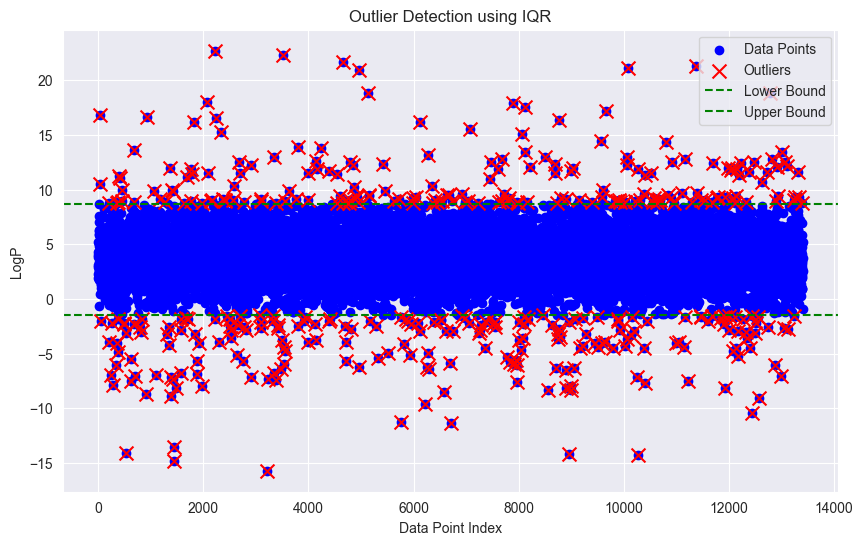

Number of outliers removed: 401


[09:07:20] SMILES Parse Error: syntax error while parsing: CC(C)MC1=C(C(N=C2NNN=N2)=O)SC(OC)=C1Br
[09:07:20] SMILES Parse Error: check for mistakes around position 6:
[09:07:20] CC(C)MC1=C(C(N=C2NNN=N2)=O)SC(OC)=C1Br
[09:07:20] ~~~~~^
[09:07:20] SMILES Parse Error: Failed parsing SMILES 'CC(C)MC1=C(C(N=C2NNN=N2)=O)SC(OC)=C1Br' for input: 'CC(C)MC1=C(C(N=C2NNN=N2)=O)SC(OC)=C1Br'
[09:07:20] Explicit valence for atom # 8 N, 4, is greater than permitted
[09:07:20] Explicit valence for atom # 9 C, 5, is greater than permitted
[09:07:20] SMILES Parse Error: extra open parentheses while parsing: N(C(N=S)CC
[09:07:20] SMILES Parse Error: check for mistakes around position 2:
[09:07:20] N(C(N=S)CC
[09:07:20] ~^
[09:07:20] SMILES Parse Error: Failed parsing SMILES 'N(C(N=S)CC' for input: 'N(C(N=S)CC'
[09:07:20] SMILES Parse Error: syntax error while parsing: C1=CC2(C3C(CC4(C)CmO)(C(=O)CO)CCC4C3CCC2=CC1=O)=O)C
[09:07:20] SMILES Parse Error: check for mistakes around position 19:
[09:07:20] C1=CC2

Number of invalid SMILES removed: 430
Number of duplicate SMILES removed: 963


[09:07:23] Explicit valence for atom # 10 C, 5, is greater than permitted
[09:07:23] non-ring atom 13 marked aromatic
[09:07:23] SMILES Parse Error: syntax error while parsing: CN(C)C1=CC(=CC(N(C)C)=C1OC)CC2=CNe(=N)NC2=N
[09:07:23] SMILES Parse Error: check for mistakes around position 34:
[09:07:23] C(N(C)C)=C1OC)CC2=CNe(=N)NC2=N
[09:07:23] ~~~~~~~~~~~~~~~~~~~~^
[09:07:23] SMILES Parse Error: Failed parsing SMILES 'CN(C)C1=CC(=CC(N(C)C)=C1OC)CC2=CNe(=N)NC2=N' for input: 'CN(C)C1=CC(=CC(N(C)C)=C1OC)CC2=CNe(=N)NC2=N'
[09:07:23] SMILES Parse Error: syntax error while parsing: O(CC)C1=CC=CC=C1OCCM
[09:07:23] SMILES Parse Error: check for mistakes around position 20:
[09:07:23] O(CC)C1=CC=CC=C1OCCM
[09:07:23] ~~~~~~~~~~~~~~~~~~~~^
[09:07:23] SMILES Parse Error: Failed parsing SMILES 'O(CC)C1=CC=CC=C1OCCM' for input: 'O(CC)C1=CC=CC=C1OCCM'
[09:07:23] SMILES Parse Error: syntax error while parsing: CC()CC(C(NC(CC=1C=CC(O)=CC=1)C(=O)O)=O)N
[09:07:23] SMILES Parse Error: check for mistakes aro

In [4]:
df = pd.read_csv('./data/final_train_data80.csv')
df = iqr_remove_outliers(df)
df = remove_invalid_molecules(df)
df = remove_duplicate_molecules(df)

## Визуализация распределения LogP
Визуализация помогает понять распределение целевой переменной, что важно для интерпретации результатов.

In [5]:
# LogP Distribution
def plot_distribution(df, column='LogP'):
    logp_values = df[column]
    
    min_logp = int(np.floor(logp_values.min()))
    max_logp = int(np.ceil(logp_values.max()))
    bins = np.arange(min_logp, max_logp + 1, 1)
    
    plt.hist(logp_values, bins=bins, edgecolor='black')
    plt.xlabel('LogP')
    plt.ylabel('Frequency')
    plt.title('Distribution of LogP values')
    plt.show()
    
    counts, bin_edges = np.histogram(logp_values, bins=bins)
    
    for i in range(len(counts)):
      print(f"Interval {bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}: {counts[i]} values")

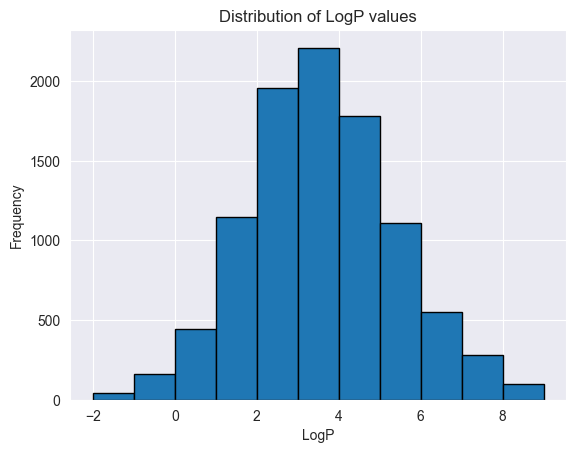

Interval -2.00 - -1.00: 40 values
Interval -1.00 - 0.00: 159 values
Interval 0.00 - 1.00: 445 values
Interval 1.00 - 2.00: 1150 values
Interval 2.00 - 3.00: 1959 values
Interval 3.00 - 4.00: 2210 values
Interval 4.00 - 5.00: 1783 values
Interval 5.00 - 6.00: 1109 values
Interval 6.00 - 7.00: 551 values
Interval 7.00 - 8.00: 279 values
Interval 8.00 - 9.00: 99 values


In [6]:
plot_distribution(df, 'LogP')

## Вычисление молекулярных дескрипторов
В данном блоке подгружаем необходимые дескрипторы

In [7]:
def add_top_descriptors(df, selected_descriptors):
    rdkit_funcs = {
        'FpDensityMorgan1': Descriptors.FpDensityMorgan1,
        'FpDensityMorgan2': Descriptors.FpDensityMorgan2,
        'HeavyAtomMolWt': Descriptors.HeavyAtomMolWt,
        'MolWt': Descriptors.MolWt,
        'NumHDonors': Descriptors.NumHDonors,
        'NumHAcceptors': Descriptors.NumHAcceptors,
        'fr_COO': Chem.Fragments.fr_COO,
        'fr_Al_COO': Chem.Fragments.fr_Al_COO,
        'fr_Ar_N': Chem.Fragments.fr_Ar_N,
        'fr_Al_OH': Chem.Fragments.fr_Al_OH,
        'fr_Ar_NH': Chem.Fragments.fr_Ar_NH,
        'fr_quatN': Chem.Fragments.fr_quatN,
        'BertzCT': Chem.GraphDescriptors.BertzCT,
    }

    rdmol_funcs = {
        'NumRings': rdMolDescriptors.CalcNumRings,
        'NumAromaticRings': rdMolDescriptors.CalcNumAromaticRings,
        'NumAromaticCarbocycles': rdMolDescriptors.CalcNumAromaticCarbocycles,
        'NumHeteroatoms': rdMolDescriptors.CalcNumHeteroatoms,
        'TPSA': rdMolDescriptors.CalcTPSA,
        'LabuteASA': rdMolDescriptors.CalcLabuteASA,
        'CalcKappa3': rdMolDescriptors.CalcKappa3,
    }

    mordred_dict = {
        'SLogP': descriptors.SLogP,
        'PEOE_VSA6': descriptors.MoeType.PEOE_VSA(6),
        'PEOE_VSA1': descriptors.MoeType.PEOE_VSA(1),
        'C2SP2': descriptors.CarbonTypes.CarbonTypes(2, 2),
        'ZMIC1': descriptors.InformationContent.ZModifiedIC(1),
        'ZMIC2': descriptors.InformationContent.ZModifiedIC(2),
        'NaasC': descriptors.EState.AtomTypeEState ('count', 'aasC'),
        'NsNh2': descriptors.EState.AtomTypeEState ('count', 'sNH2'),
        'NsOH': descriptors.EState.AtomTypeEState ('count', 'sOH'),
        'NdO': descriptors.EState.AtomTypeEState ('count', 'dO'),
        'nX': descriptors.AtomCount.AtomCount('X'),
        'nN': descriptors.AtomCount.AtomCount('N'),
        'VSA_EState6': descriptors.MoeType.VSA_EState(6),
        'SMR_VSA7': descriptors.MoeType.SMR_VSA(7),
        'AATS1p': descriptors.Autocorrelation.AATS(1, 'p'),
        'AATS1v': descriptors.Autocorrelation.AATS(1, 'v'),
        'AATS1i': descriptors.Autocorrelation.AATS(1, 'i'),
        'AATS2p': descriptors.Autocorrelation.AATS(2, 'p'),
        'AATS2v': descriptors.Autocorrelation.AATS(2, 'v'),
        'AATS1se': descriptors.Autocorrelation.AATS(1, 'se'),
        'AATS0se': descriptors.Autocorrelation.AATS(0, 'se'),
        'AATS4s': descriptors.Autocorrelation.AATS(4, 's'),
        'MATS1Z': descriptors.Autocorrelation.MATS(1, 'Z'),
        'MATS2d': descriptors.Autocorrelation.MATS(2, 'd'),
        'MATS1m': descriptors.Autocorrelation.MATS(1, 'm'),
        'MATS1pe': descriptors.Autocorrelation.MATS(1, 'pe'),
        'MATS1se': descriptors.Autocorrelation.MATS(1, 'se'),
        'SlogP_VSA7': descriptors.MoeType.SlogP_VSA(7),
        'SlogP_VSA8': descriptors.MoeType.SlogP_VSA(8),
        'nAcid': descriptors.AcidBase.AcidicGroupCount(),
        'nBase': descriptors.AcidBase.BasicGroupCount(),
        'FilterItLogS': descriptors.LogS.LogS(),
        'nBondsM': descriptors.BondCount.BondCount('multiple', False),
        'MIC0': descriptors.InformationContent.ModifiedIC(0),
        'EState_VSA5': descriptors.MoeType.EState_VSA(5),
        'IC5': descriptors.InformationContent.InformationContent(5),
        'IC0': descriptors.InformationContent.InformationContent(0)
    }

    rdkit_selected = {k: f for k, f in rdkit_funcs.items() if k in selected_descriptors}
    rdmol_selected = {k: f for k, f in rdmol_funcs.items() if k in selected_descriptors}
    mordred_selected = {k: f for k, f in mordred_dict.items() if k in selected_descriptors}

    # Подготовка Mordred-калькулятора
    mordred_calc = Calculator(list(mordred_selected.values()), ignore_3D=True) if mordred_selected else None

    def compute_all(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {name: np.nan for name in selected_descriptors}

        result = {}

        for name, func in rdkit_selected.items():
            result[name] = func(mol)

        for name, func in rdmol_selected.items():
            result[name] = func(mol)

        if mordred_calc:
            mordred_vals = mordred_calc(mol)
            for i, name in enumerate(mordred_selected.keys()):
                result[name] = mordred_vals[i]

        return result

    descriptors_df = df['SMILES'].apply(compute_all).apply(pd.Series)
    df_final = pd.concat([df, descriptors_df], axis=1)

    return df_final

def clean_data(df):
   df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
   df_clear = df.rename(str, axis="columns") 
   return df_clear

In [8]:
df = add_top_descriptors(df, DESCRIPTORS)
df = clean_data(df)

Так как заранее подготовленных валидационных данных у нас нет, создаём набор из тренировочных данных. Так как таргетная переменная - непрерывные значения, то используем псевдо-стратификацию данных, чтобы не было дисбаланса. Дробим данные на 20 групп (квантилей) и проводим разделение на train и valid, используя train_test_split. Делаем небольшой валидационный датасет (5 %), чтобы по максимуму использовать данные для тренировки.

In [9]:
# Создаём квазикатегориальную переменную для стратификации
df['stratify_bins'] = pd.qcut(df['LogP'], q=20)  # q=кол-во квантилей (групп)

train_df, val_df = train_test_split(
    df, test_size=0.05, random_state=666, stratify=df['stratify_bins']
)

train_df = train_df.drop(columns='stratify_bins')
val_df = val_df.drop(columns='stratify_bins')

Создаём объекты MoleculeDatapoint. Chemprop требует данные в формате MoleculeDatapoint для обработки молекулярных графов.

In [10]:
def create_molecule_datapoints(df, smiles_column, target_columns=None, descriptor_columns=None):
    if target_columns is not None:
        ys = df[target_columns].to_numpy()

    all_data = []
    for i, (_, row) in enumerate(df.iterrows()):
        if descriptor_columns is not None and descriptor_columns != []:
            descriptors = np.array(row[descriptor_columns], dtype=float).tolist()

            if target_columns is not None:
                datapoint = MoleculeDatapoint.from_smi(row[smiles_column], ys[i], x_d=np.array(descriptors))
            else:
                datapoint = MoleculeDatapoint.from_smi(row[smiles_column], x_d=np.array(descriptors))
        else:
            if target_columns is not None:
                datapoint = MoleculeDatapoint.from_smi(row[smiles_column], ys[i])
            else:
                datapoint = MoleculeDatapoint.from_smi(row[smiles_column])
        all_data.append(datapoint)

    return all_data

## Обучение модели
Обучает модель MPNN с параметрами из BEST_PARAMS, используя тренировочный и валидационный наборы данных. Сохраняет чекпоинты лучшей модели по val_loss в ./checkpoints.

Лучшие параметры, полученные optuna оптимизацией:
agg_type='sum': Суммирование представлений атомов.
d_h=1500: Размер скрытых слоёв в MPNN.
hidden_dim=2500: Размер скрытых слоёв в FFN.
depth=3: Глубина message passing.
ffn_num_layers=4: Количество слоёв в FFN.
batch_norm=True: Использование нормализации пакета.

In [11]:
def train_model(train_df, val_df, best_params, descriptor_cols, target_col='LogP', seed=666):
    """
    Обучает финальную модель Chemprop с лучшими параметрами и дескрипторами.

    Параметры:
    - train_df: pandas DataFrame с тренировочными данными
    - val_df: pandas DataFrame с валидационными данными
    - best_params: словарь с гиперпараметрами и выбранными дескрипторами
    - descriptor_cols: список всех дескрипторов
    - target_col: имя целевой колонки
    - seed: начальное число для воспроизводимости
    """
    # Установка начального числа
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    pl.seed_everything(seed)
    
    # Вытаскиваем оптимальные параметры из словаря
    selected_descriptors = [desc for desc in descriptor_cols if best_params.get(f'{desc}', 0) == 1]
    hidden_dim = best_params['hidden_dim']
    depth = best_params['depth']
    ffn_num_layers = best_params['ffn_num_layers']
    batch_norm = best_params['batch_norm']
    agg_type = best_params['agg_type']
    d_h = best_params['d_h']

    # Нормализация целевой переменной
    logp_scaler = StandardScaler()
    logp_scaler.fit(train_df[[target_col]])

    # Нормализация дескрипторов
    if selected_descriptors:
        desc_scaler = StandardScaler()
        desc_scaler.fit(train_df[selected_descriptors])
        X_d_transform = ScaleTransform.from_standard_scaler(desc_scaler)
    else:
        desc_scaler = None
        X_d_transform = None

    # Создание датасета
    train_datapoints = create_molecule_datapoints(train_df, 'SMILES', ['LogP'], selected_descriptors)
    val_datapoints = create_molecule_datapoints(val_df, 'SMILES', ['LogP'], selected_descriptors)

    featurizer = SimpleMoleculeMolGraphFeaturizer()

    train_dataset = MoleculeDataset(train_datapoints, featurizer)
    target_scaler = train_dataset.normalize_targets(logp_scaler)
    descriptors_scaler = train_dataset.normalize_inputs("X_d", desc_scaler)

    val_dataset = MoleculeDataset(val_datapoints, featurizer)
    val_dataset.normalize_targets(target_scaler)
    val_dataset.normalize_inputs("X_d", descriptors_scaler)
    
    num_workers = 10 if torch.cuda.is_available() else 0
    train_loader = build_dataloader(train_dataset, num_workers=num_workers)
    val_loader = build_dataloader(val_dataset, num_workers=num_workers, shuffle=False)

    # Настройка модели
    mp = BondMessagePassing(d_h=d_h, depth=depth)
    if agg_type == 'attentive':
        agg = AttentiveAggregation(output_size=d_h)
    else:
        agg_map = {'mean': MeanAggregation, 'sum': SumAggregation, 'norm': NormAggregation}
        agg = agg_map[agg_type]()
    input_dim = mp.output_dim + len(selected_descriptors) if selected_descriptors else mp.output_dim
    ffn = RegressionFFN(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        n_layers=ffn_num_layers,
        criterion=RMSE(),
        output_transform=UnscaleTransform.from_standard_scaler(target_scaler)
    )
    mpnn = MPNN(mp, agg, ffn, batch_norm, [RMSE()], X_d_transform=X_d_transform)

    checkpointing = ModelCheckpoint(
        "checkpoints",  # Directory where model checkpoints will be saved
        "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
        "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
        mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
        save_last=True,  # Always save the most recent checkpoint, even if it's not the best
    )

    # Настройка тренера
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        devices=1,
        enable_progress_bar=True,
        enable_checkpointing=True,
        logger=True,
        callbacks=[checkpointing],
    )

    # Обучение
    trainer.fit(mpnn, train_loader, val_loader)

In [12]:
train_model(train_df, val_df, BEST_PARAMS, DESCRIPTORS)

Seed set to 666
D:\Projects\Element_119_Hack\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Projects\Element_119_Hack\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Projects\Element_119_Hack\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Projects\Element_119_Hack\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
D:\Projects\Element_119_Hack\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

D:\Projects\Element_119_Hack\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Инференс модели
Загружает модель из чекпоинта, выполняет предсказания на тестовом наборе и сохраняет результаты в CSV в ./data.

In [25]:
def model_inference(test_df, weight, best_params, descriptor_cols):
    """
    Инференс модели Chemprop.

    Параметры:
    - test_df: pandas DataFrame
    - weight: чекпоинт модели .ckpt
    - best_params: словарь с гиперпараметрами и выбранными дескрипторами
    - descriptor_cols: список всех дескрипторов
    """
    selected_descriptors = [desc for desc in descriptor_cols if best_params.get(f'{desc}', 0) == 1]
    
    # Создаём датасет
    test_data = create_molecule_datapoints(test_df, 'SMILES', target_columns=None, descriptor_columns=selected_descriptors)
    
    featurizer = SimpleMoleculeMolGraphFeaturizer()
    
    test_dset = MoleculeDataset(test_data, featurizer=featurizer)
    test_loader = build_dataloader(test_dset, shuffle=False)
    
    # Инициализируем модель и запускаем инференс
    mpnn = load_model(weight, multicomponent=False)
    with torch.inference_mode():
        trainer = pl.Trainer(
            logger=None,
            enable_progress_bar=True,
            accelerator="auto",
            devices=1
        )
        test_preds = trainer.predict(mpnn, test_loader)
    
    # Сохранение результатов
    test_preds = np.concatenate(test_preds, axis=0)
    test_df['LogP'] = test_preds
    test_df = test_df[['ID', 'LogP']]
    test_df.to_csv('./data/test_predictions.csv', index=False)
    print('Predictions saved to ./data/test_predictions.csv')

In [26]:
test_df = pd.read_csv('./data/final_test_data80.csv')
test_df = add_top_descriptors(test_df, DESCRIPTORS)

Чекпоинт указывается вручную, чтобы была возможность экспериментировать с разными моделями

In [27]:
CHECKPOINT = './checkpoints/best-epoch=26-val_loss=0.36.ckpt'

In [28]:
model_inference(test_df, CHECKPOINT, BEST_PARAMS, DESCRIPTORS)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
D:\Projects\Element_119_Hack\.venv\Lib\site-packages\lightning\pytorch\core\saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
D:\Projects\Element_119_Hack\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]